In [11]:
import numpy as np
import random as rd
import math

import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import src.privacy_ml as ml #import split_horizontally, split_into_random_subsets, stepForward, stepForwardMono, stepForward_2
import src.logistic_reg as lr #import cost
import src.util as util

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
num_agents = 10
seed = 42

T = 1000
mu = 0.05

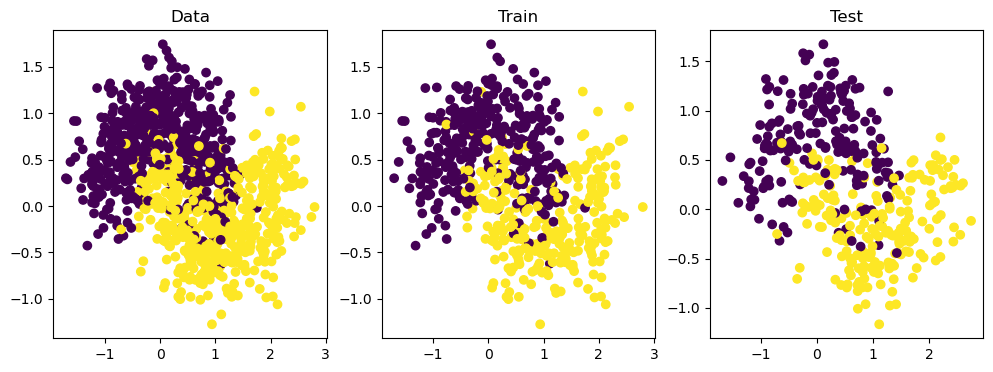

In [13]:
X, Y = make_moons(n_samples=1000, noise=0.3)


Y_formated = OneHotEncoder(categories='auto').fit_transform(Y.reshape(-1,1)).toarray()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=seed, test_size=0.4)
plt.figure(figsize=(12,4))
plt.subplot(1, 3, 1)
plt.scatter(X[:,0], X[:,1], c=Y)
plt.title("Data")
plt.subplot(1, 3, 2)
plt.scatter(X_train[:,0], X_train[:,1], c=Y_train)
plt.title("Train")
plt.subplot(1, 3, 3)
plt.scatter(X_test[:,0], X_test[:,1], c=Y_test)
plt.title("Test")
plt.show()


On va trier les points par rapport à leur abscisse, pour simuler un effet de proximité entre les points, et utiliser cette proximité pour délimiter les différents agents.

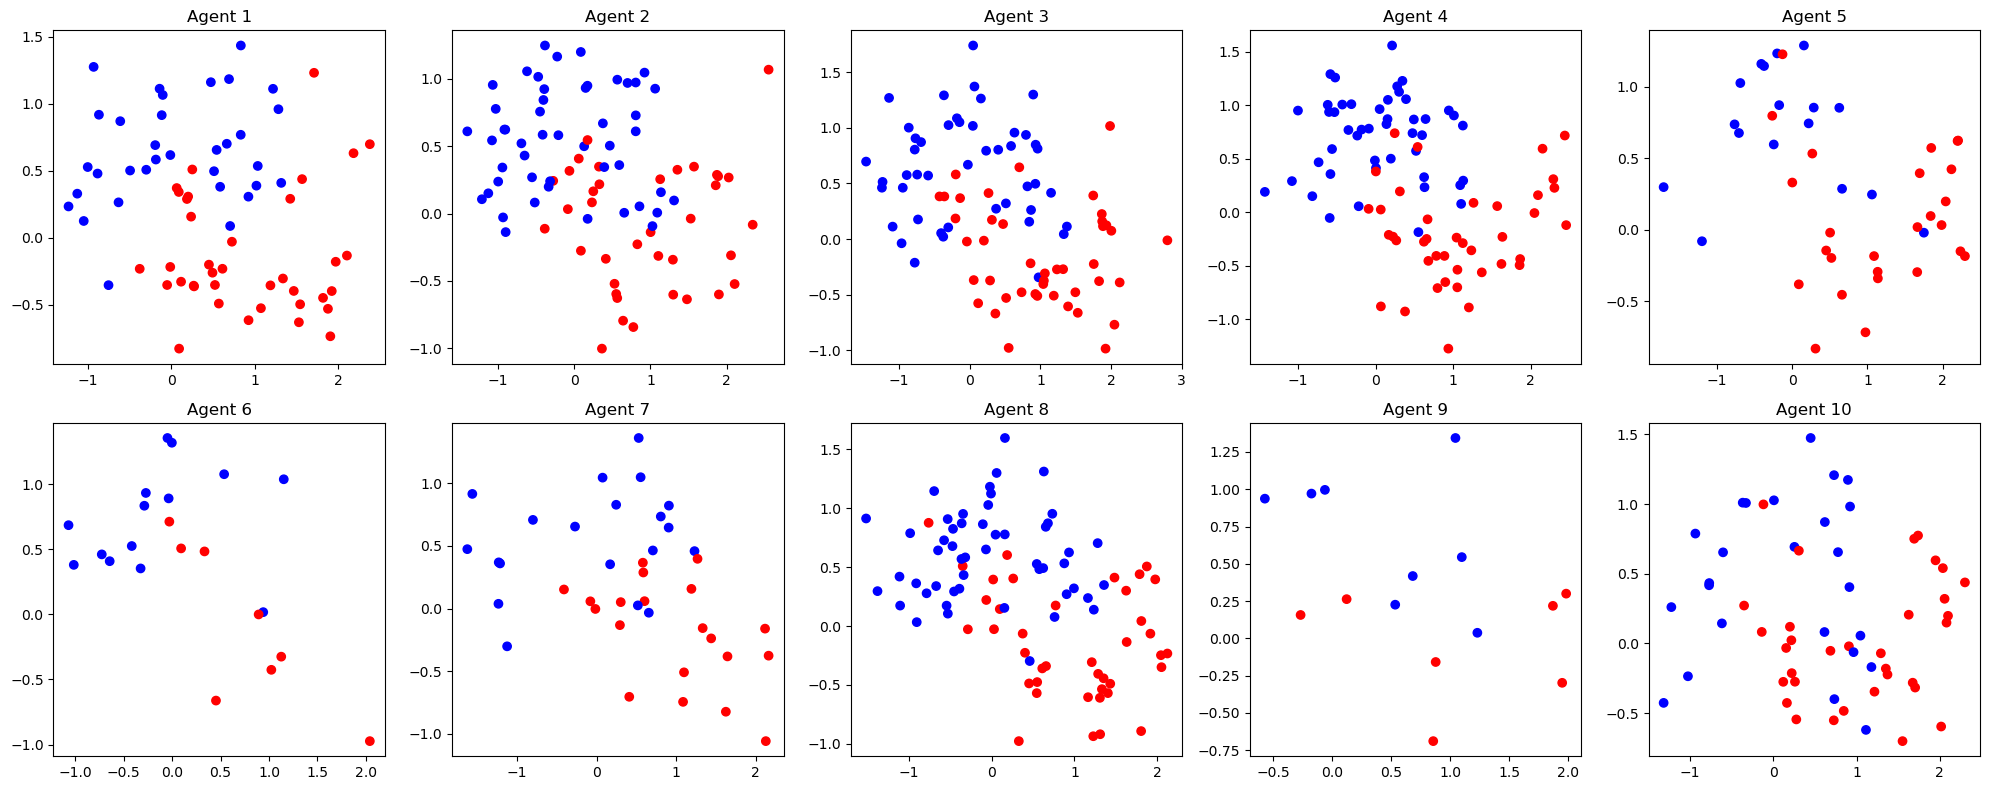

In [14]:

X_agent, Y_agent = ml.split_into_random_subsets(X_train, Y_train, random_state=seed)
#X_agent, Y_agent = ml.split_horizontally(X_train, Y_train)


fig, axes = plt.subplots(nrows=2, ncols=int(num_agents/2), figsize=(20, 8))

for i in range(num_agents):
    row = i // (num_agents // 2)
    col = i % (num_agents // 2)
    colors = ['blue' if y== 0 else 'red' for y in Y_agent[i]]
    axes[row, col].scatter(X_agent[i][:,0], X_agent[i][:,1], c=colors)
    axes[row, col].set_title(f'Agent {i+1}')

plt.tight_layout()
plt.show()

In [15]:
X_agent_augmented = []
for i in range(num_agents):
    X_agent_augmented.append(np.concatenate([X_agent[i], X_agent[i]**2, X_agent[i]**3, X_agent[i]**4, X_agent[i]**5], axis=1))

In [16]:
X_test_augmented = np.concatenate([X_test, X_test**2, X_test**3, X_test**4, X_test**5], axis=1)
X_train_augmented = np.concatenate([X_train, X_train**2, X_train**3, X_train**4, X_train**5], axis=1)

In [17]:
G = np.zeros((num_agents, num_agents))
for i in range(num_agents):
    for j in range(num_agents):
        if j == i+1 or j == i-1:
            G[i,j] = 1  
    
D = np.zeros(num_agents)
c = np.zeros(num_agents)

maxSize = np.max([x.shape[0] for x in X_agent])
print(f"Max: {maxSize}")
minSize = np.min([x.shape[0] for x in X_agent])
print(f"Min: {minSize}")
meanSize = np.mean([x.shape[0] for x in X_agent])
print(f"Mean: {meanSize}")
for i in range(num_agents):
    D[i] = np.sum(G[i,:])
    c[i] = X_agent[i].shape[0]/maxSize

print(f"G: {G}")
print(f"D: {D}")
print(f"c: {c}")

Max: 91
Min: 15
Mean: 60.0
G: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
D: [1. 2. 2. 2. 2. 2. 2. 2. 2. 1.]
c: [0.76923077 0.94505495 0.97802198 0.94505495 0.47252747 0.24175824
 0.43956044 1.         0.16483516 0.63736264]


## Logistic Regression and Gradient Descent


In linear regression, we got a real-valued response
	
$$\hat{y} = \theta_0 + \theta_1 x_1 + \cdots + \theta_d x_d,$$
    
i.e., a linear combination of inputs, where $\hat{y} \in \mathbf{R}$.

In classification, we want an *indication* of how likely an instance is to belong to a particular class; a probability $\in [0,1]$.  

Given a real valued $z$, we can squish it to range $\sigma(z) \in [0,1]$ by feeding it through the **logistic function** aka **sigmoid function**:
		
\begin{equation}
\sigma(z) = \frac{1}{1+\exp(-z)}. \hspace{1.5cm}(1)
\end{equation}

Which looks like this: ![Sigmoid](https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/320px-Logistic-curve.svg.png)

Therefore, we can treat this as a probability, i.e.,

\begin{align*}
P(y=1|\mathbf{x}) &= \sigma(\mathbf{\theta}^\top\mathbf{x}), \\
P(y=0|\mathbf{x}) &= 1 - \sigma(\mathbf{\theta}^\top\mathbf{x}), 
\end{align*}

where we omit the bias term and suppose that both $\mathbf{\theta}$ and $\mathbf{x}$ are column vectors.

In order to chose values for the parameters of logistic regression, we use **maximum likelihood estimation** (MLE). As such we are going to have two steps:

1. write the likelihood function;
2. find the values of $\theta$ that maximize the log-likelihood function.


We begin by defining the design matrix $X \in \mathbb{R}^{n,d}$ containing our data points $x_i^T \in \mathbb{R}^{1\times d}$ on its rows and our column vector of model paramters $\theta \in \mathbb{R}^{d\times 1}.$
The labels that we are predicting are binary, this means that we can interpret each label as a Bernoulli random variable: $Y \sim Ber(p)$ where $p = \sigma(\mathbf{\theta}^\top\mathbf{x})$.

Therefore, we can write the probability of a data point as
$$
P\left(Y=y|X=\mathbf{x}\right) = \sigma(\mathbf{\theta}^\top\mathbf{x})^y \cdot \left[1-\sigma(\mathbf{\theta}^\top\mathbf{x})\right]^{(1-y)}.
$$

Given this probability mass function we can now write the **likelihood** of the whole dataset

\begin{equation}
L(\theta) = \prod_{i=1}^n P(Y = y_i|\mathbf{X} = \mathbf{x}_i) = \prod_{i=1}^n \sigma(\mathbf{\theta}^\top\mathbf{x}_i)^{y_i} \cdot \left[1-\sigma(\mathbf{\theta}^\top\mathbf{x}_i)\right]^{(1-y_i)}. \hspace{1.5cm}(2)
\end{equation}

We can take the log of this function to transform the product into a sum and by doing that, we obtain the **log-likelihood**

\begin{equation}
LL(\theta) = \sum_{i=1}^n \left( y_i\log{\sigma(\mathbf{\theta}^\top\mathbf{x}_i)} + (1-y_i) \log{\left[1-\sigma(\mathbf{\theta}^\top\mathbf{x}_i)\right]} \right). \hspace{1.5cm}(3)
\end{equation}

As you will remember from the first lab, our objective is to minimize the error by fitting our model to the data. However, the log-likelihood increases when the model is fitting better to the data. That's the reason why in logistic regression we take the *negative* log-likelihood (also known as **cost** function $E(\theta)$).

On a : $l(\theta) = - \sum_{i=1}^n \left( y_i\log{\sigma(\mathbf{\theta}^\top\mathbf{x}_i)} + (1-y_i) \log{\left[1-\sigma(\mathbf{\theta}^\top\mathbf{x}_i)\right]} \right).$
donc la dérivée vaut : $\nabla _\theta l(\theta) = -\sum_{i=1}^n y_i (1-\sigma(\theta^Tx_i))x_i - (1-y_i) \sigma(\theta^Tx_i)x_i $

$ \nabla_\theta l(\theta) = -\sum_{i=1}^n (y_i - \sigma(\theta^Tx_i)) x_i $

Besoin du coeff de Lipschitz mais : https://proceedings.neurips.cc/paper_files/paper/2018/file/d54e99a6c03704e95e6965532dec148b-Paper.pdf

Supposons que le sigmoid soit L-lip
Alors 

$ \nabla_\theta l(\theta_0) - \nabla_\theta l(\theta_1)  = -\sum_{i=1}^n (\sigma(\theta_1^Tx_i) - \sigma(\theta_0^Tx_i)) x_i$

$| \nabla_\theta l(\theta_0) - \nabla_\theta l(\theta_1) |_2 \leq \sum_{i=1}^n L|(\theta_1^T - \theta_0^T)x_i| | x_i |_2  \leq \sum_{i=1}^n L|\theta_1^T - \theta_0|_2 |x_i|_2 | x_i |_2 $

Or on a $L = \frac{1}{4} $


## Training

### Single Global Model

In [18]:
np.random.seed(seed)
thetas_mono = np.random.rand(X_train_augmented.shape[1])
costs_train_mono = np.zeros((T))
costs_test_mono = np.zeros((T))

train_acc = np.zeros((T))
test_acc = np.zeros((T))

for i in range(T):
    thetas_mono = ml.stepForwardMono(thetas_mono, X_train_augmented, Y_train)
    costs_train_mono[i] = lr.cost(thetas_mono, X_train_augmented, Y_train)
    costs_test_mono[i] = lr.cost(thetas_mono, X_test_augmented, Y_test)

    train_acc[i] = lr.accuracy(thetas_mono, X_train_augmented, Y_train)
    test_acc[i] = lr.accuracy(thetas_mono, X_test_augmented, Y_test)

    if i % (T/10) == 0:
                print(f'Iteration {i} : Train: {costs_train_mono[i]:.4f} | Test: {costs_test_mono[i]:.4f}')

# np.random.seed(seed)
# thetas_agents_globalModel = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]

# costs_train_agents_globalModel = np.zeros((T, num_agents))
# costs_test_agents_globalModel = np.zeros((T, num_agents))

# print(T)
# for i in range(T):
#     thetas_agents_globalModel = ml.stepForward(thetas_agents_globalModel, X_agent_augmented, Y_agent, num_agents, 0, c, G, D)
#     for j in range(num_agents):
#             costs_train_agents_globalModel[i,j] = lr.cost(thetas_agents_globalModel[j], X_agent_augmented[j], Y_agent[j])
#             costs_test_agents_globalModel[i,j] = lr.cost(thetas_agents_globalModel[j], X_test_augmented, Y_test)
#     if i % 1000 == 0 :
#         print(f'Iteration {i+1} : Train: {np.mean(costs_train_agents_globalModel[i]):.4f} and {np.std(costs_train_agents_globalModel[i]):.4f} | Test: {np.mean(costs_test_agents_globalModel[i]):.4f} and {np.std(costs_test_agents_globalModel[i]):.4f}')

Iteration 0 : Train: 1.4939 | Test: 1.5787
Iteration 100 : Train: 0.9674 | Test: 1.0016
Iteration 200 : Train: 0.5914 | Test: 0.5767
Iteration 300 : Train: 0.4849 | Test: 0.4673
Iteration 400 : Train: 0.4445 | Test: 0.4270
Iteration 500 : Train: 0.4211 | Test: 0.4034
Iteration 600 : Train: 0.4053 | Test: 0.3873
Iteration 700 : Train: 0.3938 | Test: 0.3755
Iteration 800 : Train: 0.3850 | Test: 0.3663
Iteration 900 : Train: 0.3779 | Test: 0.3590


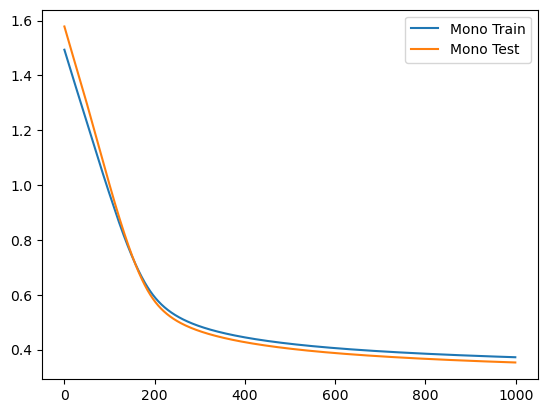

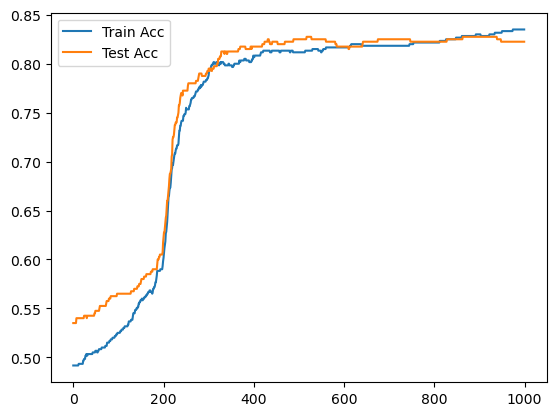

In [19]:
plt.plot(costs_train_mono, label="Mono Train")
plt.plot(costs_test_mono, label="Mono Test")
plt.legend()
plt.show()

plt.plot(train_acc, label="Train Acc")
plt.plot(test_acc, label="Test Acc")
plt.legend()
plt.show()

# util.plot_curves(num_agents, costs_train_agents_globalModel, costs_test_agents_globalModel, "Multiple Agents")

### Multiple agents

Agents dont share their models (perfectly private baseline)

In [20]:
np.random.seed(seed)
thetas_agents_alone = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]

costs_train_agents_alone = np.zeros((T, num_agents))
costs_test_agents_alone = np.zeros((T, num_agents))
costs_train_alone = np.zeros(T)
costs_test_alone = np.zeros(T)
acc_train_agents_alone = np.zeros((T, num_agents))
acc_test_agents_alone = np.zeros((T, num_agents))

print("Iter: Agents_Mean       | Total ")
for i in range(T):
    thetas_agents_alone = ml.stepForwardAlone(thetas_agents_alone, X_agent_augmented, Y_agent, num_agents)
    for j in range(num_agents):
            costs_train_agents_alone[i,j] = lr.cost(thetas_agents_alone[j], X_agent_augmented[j], Y_agent[j])
            costs_test_agents_alone[i,j] = lr.cost(thetas_agents_alone[j], X_test_augmented, Y_test)

            acc_train_agents_alone[i, j] = lr.accuracy(thetas_agents_alone[j], X_agent_augmented[j], Y_agent[j])
            acc_test_agents_alone[i, j] = lr.accuracy(thetas_agents_alone[j], X_test_augmented, Y_test)

    costs_train_alone[i] = lr.costDecentralized(thetas_agents_alone, X_agent_augmented, Y_agent, num_agents, G, D, c, mu)
    costs_test_alone[i] = lr.costDecentralized(thetas_agents_alone, X_test_augmented, Y_test, num_agents, G, D, c, mu)

    if i % (T/10) == 0 :
        print(f'{i:3} : ({np.mean(costs_train_agents_alone[i]):.4f} , {np.mean(costs_test_agents_alone[i]):.4f}) | ({costs_train_alone[i]:.4f} , {costs_test_alone[i]:.4f})')

Iter: Agents_Mean       | Total 
  0 : (1.3825 , 1.3572) | (8.7287 , 8.0863)
100 : (0.7054 , 0.7382) | (10.2504 , 9.8848)
200 : (0.5112 , 0.5287) | (9.7940 , 9.5132)
300 : (0.4407 , 0.4533) | (9.5428 , 9.2987)
400 : (0.4059 , 0.4198) | (9.6800 , 9.4572)
500 : (0.3853 , 0.4007) | (9.9973 , 9.7873)
600 : (0.3714 , 0.3882) | (10.4176 , 10.2164)
700 : (0.3612 , 0.3793) | (10.9140 , 10.7190)
800 : (0.3532 , 0.3726) | (11.4704 , 11.2802)
900 : (0.3467 , 0.3674) | (12.0757 , 11.8895)


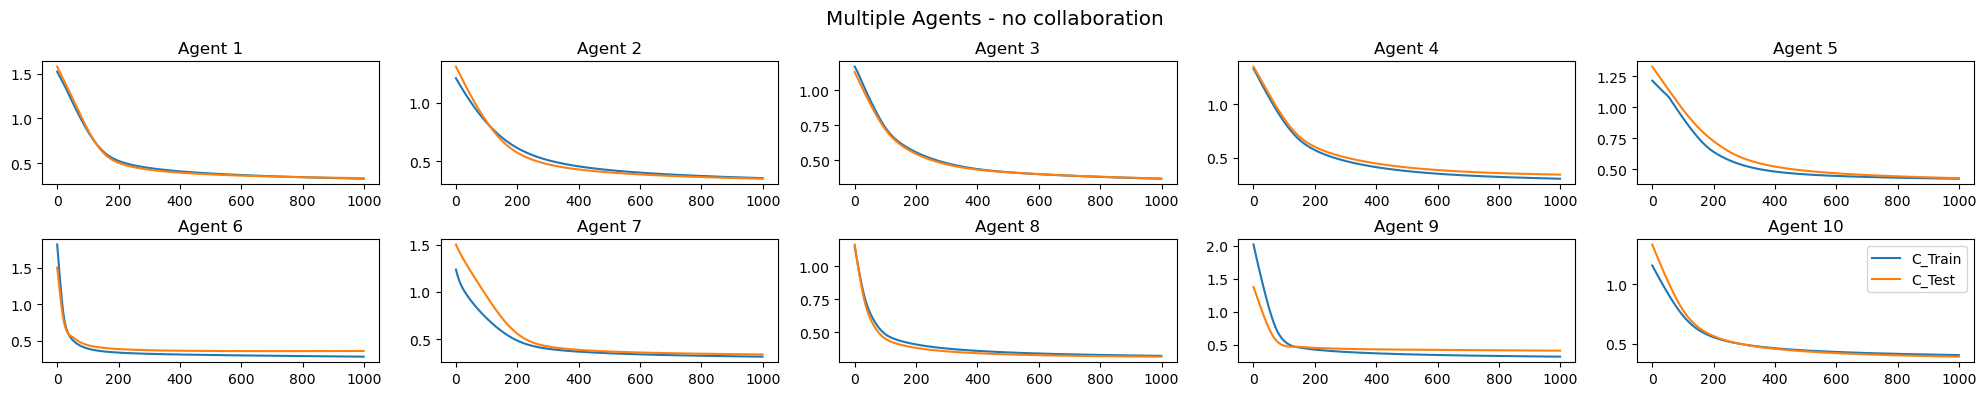

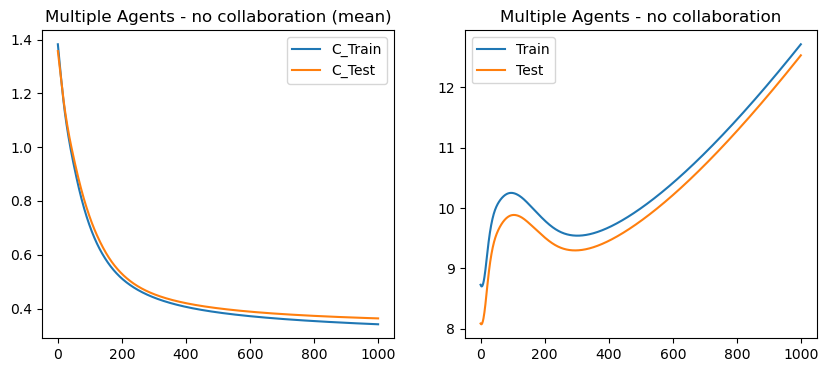

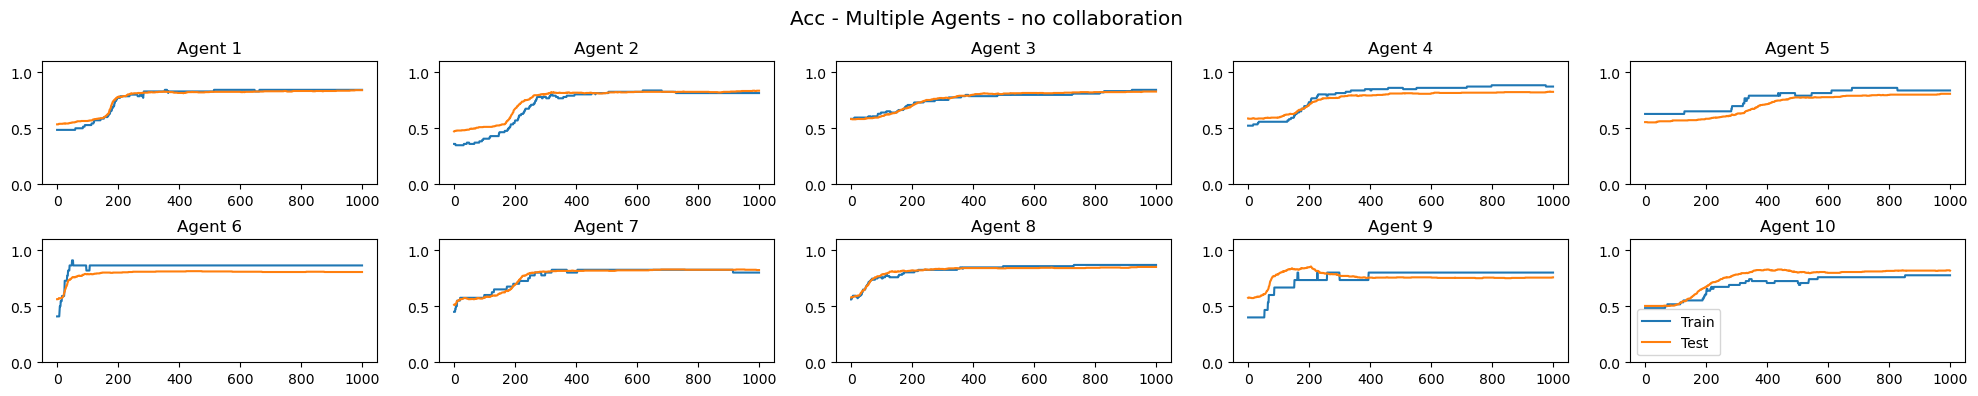

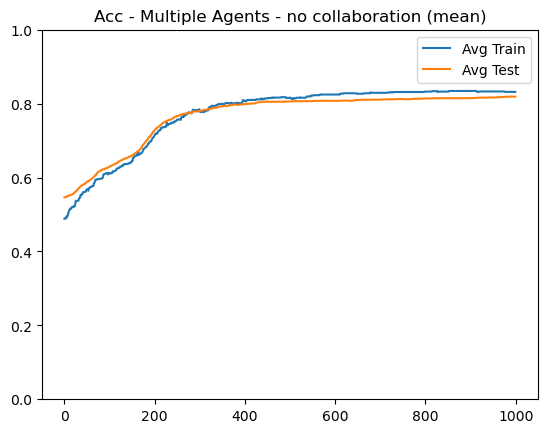

In [21]:
util.plot_curves(num_agents, costs_train_agents_alone, costs_test_agents_alone, costs_train_alone, costs_test_alone, "Multiple Agents - no collaboration")
util.plot_accuracy(num_agents, acc_train_agents_alone, acc_test_agents_alone, "Acc - Multiple Agents - no collaboration")

### Multiple agents

All agents do a step after each other in a naive queue and share their models

In [22]:
np.random.seed(seed)
thetas_agents = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]

costs_train_agents = np.zeros((T, num_agents))
costs_test_agents = np.zeros((T, num_agents))
costs_train = np.zeros(T)
costs_test = np.zeros(T)
acc_train_agents = np.zeros((T, num_agents))
acc_test_agents = np.zeros((T, num_agents))

print("Iter: Agents_Mean       | Total ")
for i in range(T):
    thetas_agents = ml.stepForward(thetas_agents, X_agent_augmented, Y_agent, num_agents, mu, c, G, D)
    for j in range(num_agents):
            costs_train_agents[i,j] = lr.cost(thetas_agents[j], X_agent_augmented[j], Y_agent[j])
            costs_test_agents[i,j] = lr.cost(thetas_agents[j], X_test_augmented, Y_test)

            acc_train_agents[i,j] = lr.accuracy(thetas_agents[j], X_agent_augmented[j], Y_agent[j])
            acc_test_agents[i,j] = lr.accuracy(thetas_agents[j], X_test_augmented, Y_test)
    costs_train[i] = lr.costDecentralized(thetas_agents, X_agent_augmented, Y_agent, num_agents, G, D, c, mu)
    costs_test[i] = lr.costDecentralized(thetas_agents, X_test_augmented, Y_test, num_agents, G, D, c, mu)
    if i % (T/10) == 0 :
        print(f'{i:3} : ({np.mean(costs_train_agents[i]):.4f} , {np.mean(costs_test_agents[i]):.4f}) | ({costs_train[i]:.4f} , {costs_test[i]:.4f})')

Iter: Agents_Mean       | Total 
  0 : (1.3782 , 1.3541) | (7.7320 , 7.0900)
100 : (0.7212 , 0.7065) | (1.8534 , 1.4692)
200 : (0.5169 , 0.5004) | (1.1303 , 0.8447)
300 : (0.4465 , 0.4338) | (0.8207 , 0.5752)
400 : (0.4136 , 0.4018) | (0.6502 , 0.4247)
500 : (0.3945 , 0.3829) | (0.5542 , 0.3404)
600 : (0.3819 , 0.3704) | (0.4952 , 0.2890)
700 : (0.3730 , 0.3613) | (0.4560 , 0.2554)
800 : (0.3661 , 0.3543) | (0.4285 , 0.2321)
900 : (0.3607 , 0.3487) | (0.4083 , 0.2152)


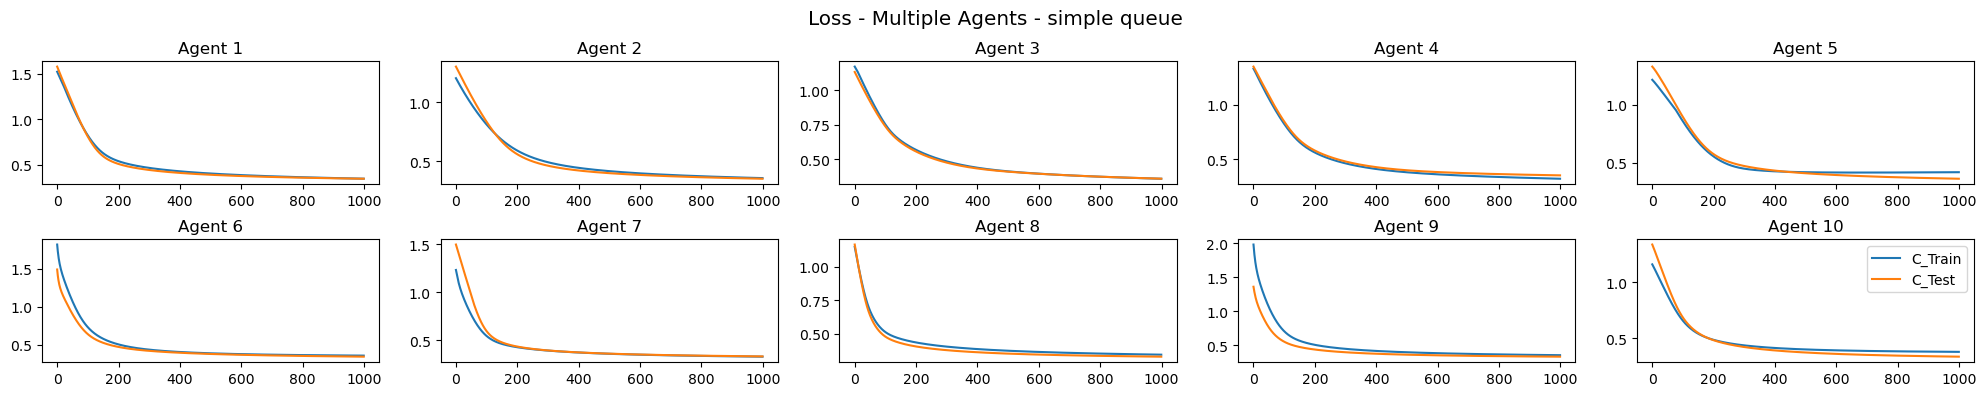

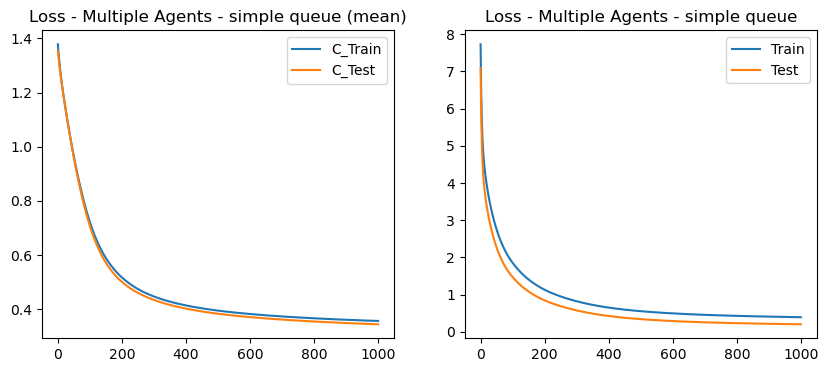

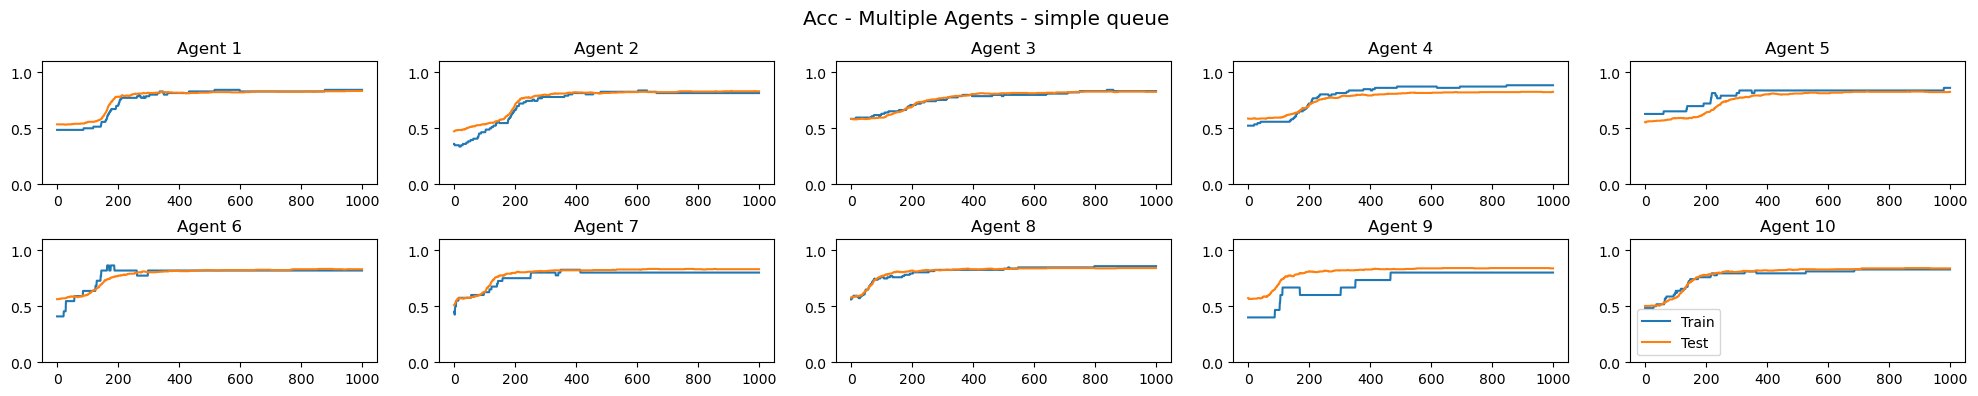

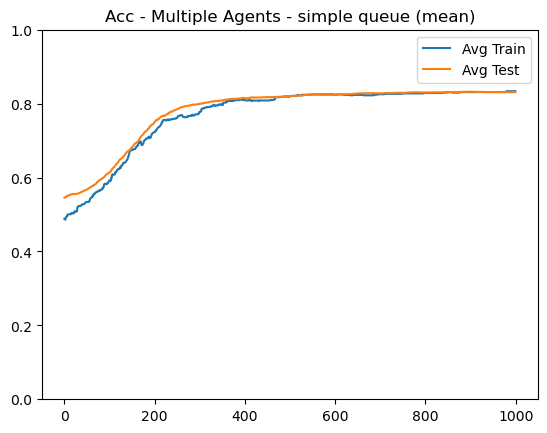

In [23]:
util.plot_curves(num_agents, costs_train_agents, costs_test_agents, costs_train, costs_test, "Loss - Multiple Agents - simple queue")
util.plot_accuracy(num_agents, acc_train_agents, acc_test_agents, "Acc - Multiple Agents - simple queue")

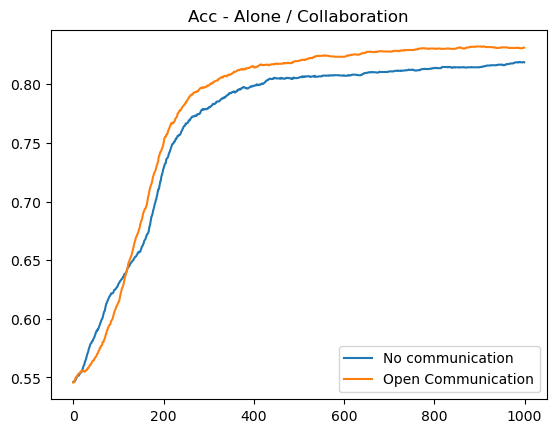

In [24]:
plt.plot(np.mean(acc_test_agents_alone, axis=1), label="No communication")
plt.plot(np.mean(acc_test_agents, axis=1), label="Open Communication")
plt.legend()
plt.title("Acc - Alone / Collaboration")
plt.show()

### Random drawing of Agents

randint with global quota

In [25]:
np.random.seed(seed)
tracking  = np.zeros(num_agents) # pour mesurer le nombre de fois que chaque agent passe
total_T = T*num_agents

thetas_agents_rand = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]
costs_test_agents_rand = np.zeros((total_T, num_agents))                 # ici on ne gardera en mémoire que les dernières valeurs
costs_train_agents_rand = np.zeros((total_T, num_agents))
costs_test_rand = np.zeros(total_T)
costs_train_rand = np.zeros(total_T)

acc_test_agents_rand = np.zeros((total_T, num_agents))               
acc_train_agents_rand = np.zeros((total_T, num_agents))


print("Iter: Agents_Mean       | Total ")
for i in range (total_T) :
    j = rd.randint(0, num_agents-1)
    tracking[j] += 1

    thetas_agents_rand = ml.stepForward_2(thetas_agents_rand, X_agent_augmented, Y_agent, j, num_agents, mu, c, G, D) 

    costs_train_agents_rand[i, j] = lr.cost(thetas_agents_rand[j], X_agent_augmented[j], Y_agent[j])
    costs_test_agents_rand[i, j] = lr.cost(thetas_agents_rand[j], X_test_augmented, Y_test)

    acc_train_agents_rand[i, j] = lr.accuracy(thetas_agents_rand[j], X_agent_augmented[j], Y_agent[j])
    acc_test_agents_rand[i, j] = lr.accuracy(thetas_agents_rand[j], X_test_augmented, Y_test)

    if i % 10 == 0:
        costs_train_rand[int(i/10)] = lr.costDecentralized(thetas_agents_rand, X_agent_augmented, Y_agent, num_agents, G, D, c, mu)
        costs_test_rand[int(i/10)] = lr.costDecentralized(thetas_agents_rand, X_test_augmented, Y_test, num_agents, G, D, c, mu)
        
    if i % ((T/10)*num_agents) == 0 :
        print(f'{int(i/num_agents):3} : ({np.mean(costs_train_agents_rand[i]):.4f} , {np.mean(costs_test_agents_rand[i]):.4f}) | ({costs_train_rand[int(i/10)]:.4f} , {costs_test_rand[int(i/10)]:.4f})')

costs_train_agents_rand = util.reduce_cost_matrix(costs_train_agents_rand)
costs_test_agents_rand = util.reduce_cost_matrix(costs_test_agents_rand)
costs_train_rand = costs_train_rand[:T]
costs_test_rand = costs_test_rand[:T]

acc_train_agents_rand = util.reduce_cost_matrix(acc_train_agents_rand)
acc_test_agents_rand = util.reduce_cost_matrix(acc_test_agents_rand)

Iter: Agents_Mean       | Total 
  0 : (0.1981 , 0.1361) | (8.3301 , 7.6836)
100 : (0.0560 , 0.0617) | (1.9160 , 1.5297)
200 : (0.0507 , 0.0438) | (1.1698 , 0.8818)
300 : (0.0459 , 0.0437) | (0.8420 , 0.5969)
400 : (0.0419 , 0.0403) | (0.6717 , 0.4464)
500 : (0.0373 , 0.0351) | (0.5623 , 0.3488)
600 : (0.0383 , 0.0373) | (0.4954 , 0.2894)
700 : (0.0344 , 0.0346) | (0.4607 , 0.2601)
800 : (0.0370 , 0.0361) | (0.4348 , 0.2384)
900 : (0.0361 , 0.0354) | (0.4115 , 0.2184)


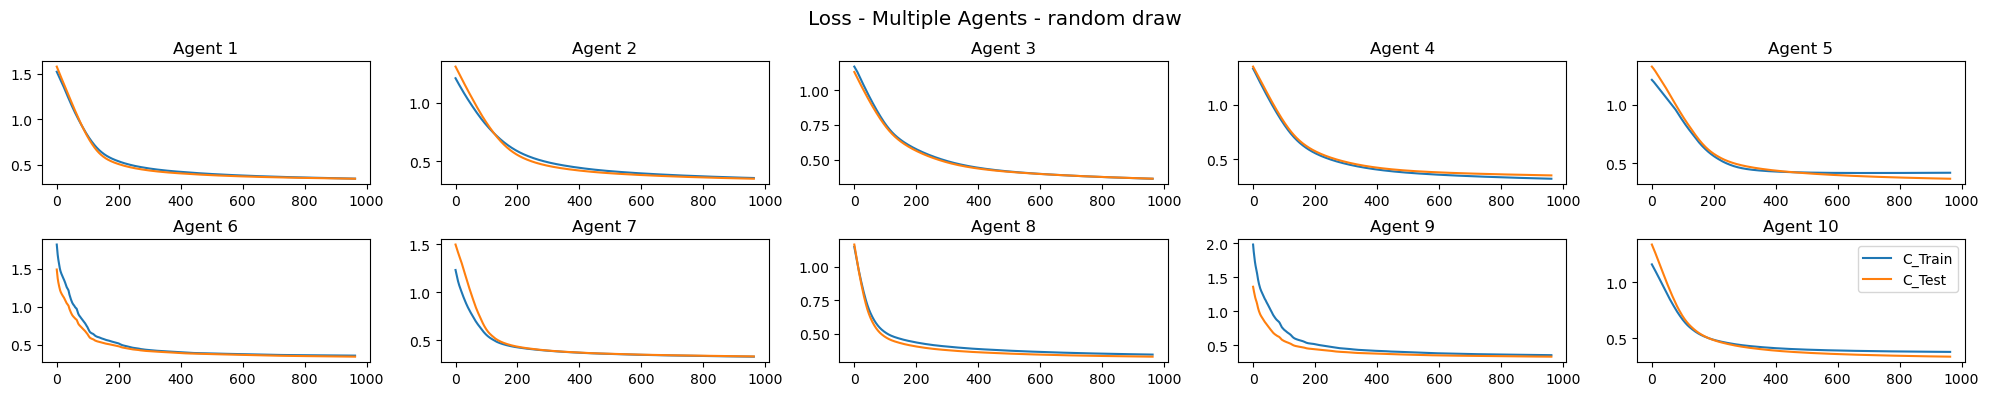

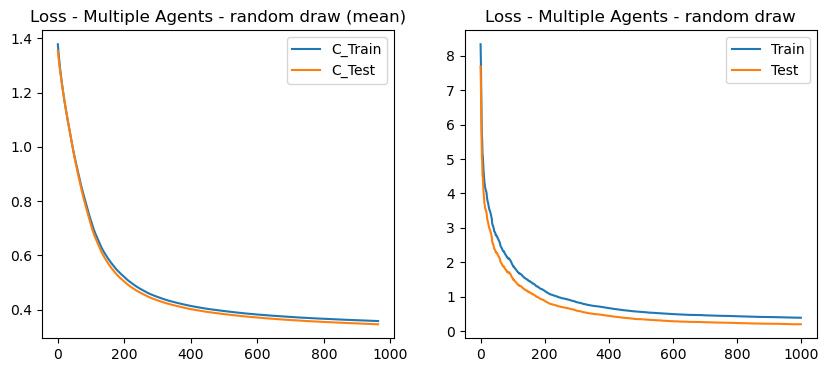

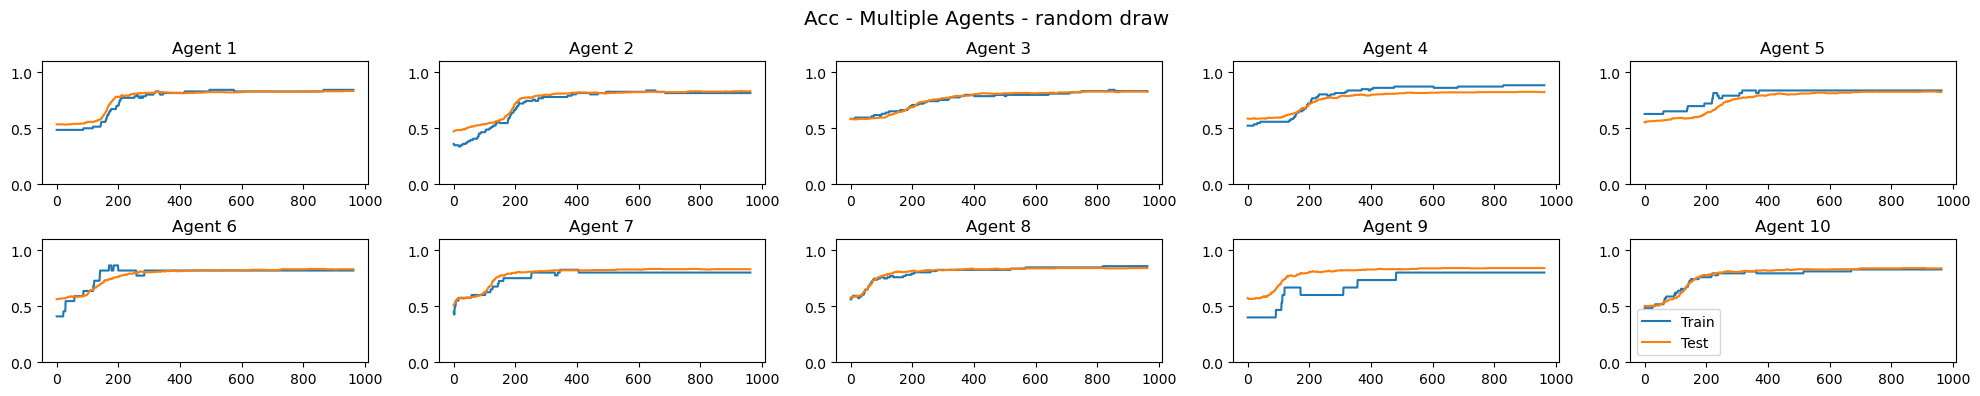

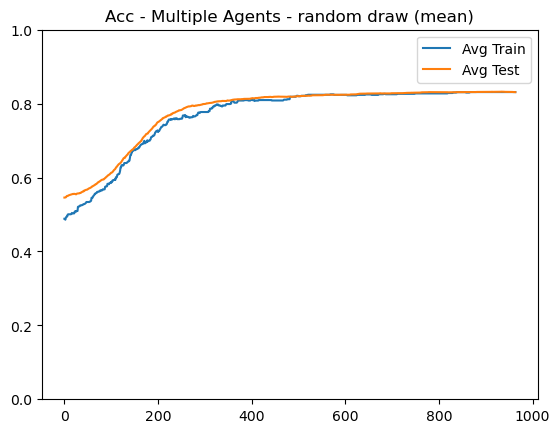

In [26]:
util.plot_curves(num_agents, costs_train_agents_rand, costs_test_agents_rand, costs_train_rand, costs_test_rand, "Loss - Multiple Agents - random draw")
util.plot_accuracy(num_agents, acc_train_agents_rand, acc_test_agents_rand, "Acc - Multiple Agents - random draw")

### Weighting of Agents

In [27]:
np.random.seed(seed)
tracking  = np.zeros(num_agents)
total_T = T*num_agents

thetas_agents_weigh = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]
costs_test_agents_weigh = np.zeros((total_T, num_agents))                 # ici on ne gardera en mémoire que les dernières valeurs
costs_train_agents_weigh = np.zeros((total_T, num_agents))
costs_test_weigh = np.zeros(total_T)
costs_train_weigh = np.zeros(total_T)


# on obtient les probabilités qu'on veut pour chaque modèle à chaque tirage
coeffs_pond = np.zeros(num_agents)
c_tot = 0
for i in range (len(c)) :
    c_tot += c[i]    
for i in range (len(c)) :
    coeffs_pond[i] = c[i]/c_tot
    
print(coeffs_pond)
print("Iter: Agents_Mean       | Total ")

for i in range(total_T) :
    j = np.random.choice(10, 1, p=coeffs_pond)[0]
    tracking[j] += 1

    thetas_agents_weigh = ml.stepForward_2(thetas_agents_weigh, X_agent_augmented, Y_agent, j, num_agents, mu, c, G, D) 

    costs_train_agents_weigh[i, j] = (lr.cost(thetas_agents_weigh[j], X_agent_augmented[j], Y_agent[j]))
    costs_test_agents_weigh[i, j] = (lr.cost(thetas_agents_weigh[j], X_test_augmented, Y_test))

    if i % 10 == 0:
        costs_train_weigh[int(i/10)] = lr.costDecentralized(thetas_agents_weigh, X_agent_augmented, Y_agent, num_agents, G, D, c, mu)
        costs_test_weigh[int(i/10)] = lr.costDecentralized(thetas_agents_weigh, X_test_augmented, Y_test, num_agents, G, D, c, mu)
        
        
    if i % ((T/10)*num_agents) == 0 :
        print(f'{int(i/num_agents):3} : ({np.mean(costs_train_agents_weigh[i]):.4f} , {np.mean(costs_test_agents_weigh[i]):.4f}) | ({costs_train_weigh[int(i/10)]:.4f} , {costs_test_weigh[int(i/10)]:.4f})')

# costs_train_agents_weigh = util.reduce_cost_matrix(costs_train_agents_weigh)
# costs_test_agents_weigh = util.reduce_cost_matrix(costs_test_agents_weigh)

costs_train_agents_weigh_shifted = util.shift_non_zero_costs_to_front(costs_train_agents_weigh)
costs_test_agents_weigh_shifted = util.shift_non_zero_costs_to_front(costs_test_agents_weigh)

non_zero_counts = np.count_nonzero(costs_train_agents_weigh_shifted, axis=0)    
max_non_zero = np.max(non_zero_counts)
costs_train_weigh = costs_train_weigh[:max_non_zero]
costs_test_weigh = costs_test_weigh[:max_non_zero]


[0.11666667 0.14333333 0.14833333 0.14333333 0.07166667 0.03666667
 0.06666667 0.15166667 0.025      0.09666667]
Iter: Agents_Mean       | Total 
  0 : (0.1520 , 0.1576) | (8.7394 , 8.0922)
100 : (0.0702 , 0.0674) | (2.0043 , 1.6448)
200 : (0.0508 , 0.0510) | (1.1545 , 0.8827)
300 : (0.0427 , 0.0409) | (0.7982 , 0.5639)
400 : (0.0426 , 0.0409) | (0.6179 , 0.4015)
500 : (0.0358 , 0.0378) | (0.5189 , 0.3126)
600 : (0.0371 , 0.0372) | (0.4700 , 0.2704)
700 : (0.0350 , 0.0348) | (0.4343 , 0.2396)
800 : (0.0353 , 0.0336) | (0.4106 , 0.2198)
900 : (0.0417 , 0.0367) | (0.3857 , 0.1980)


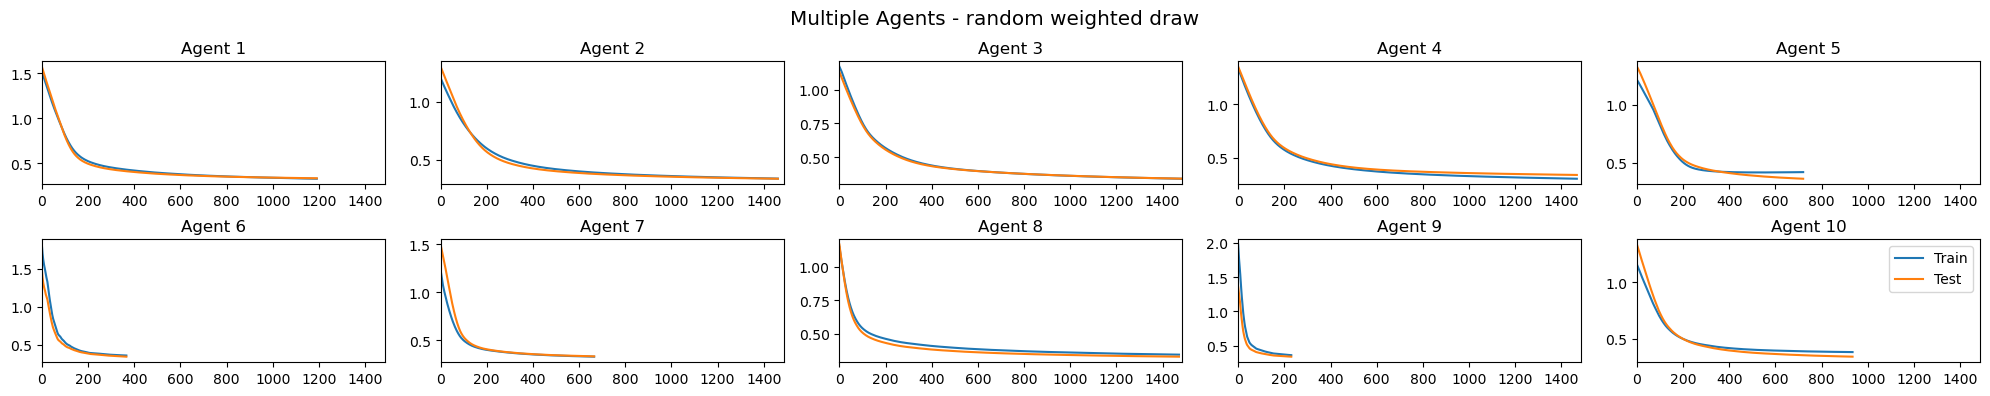

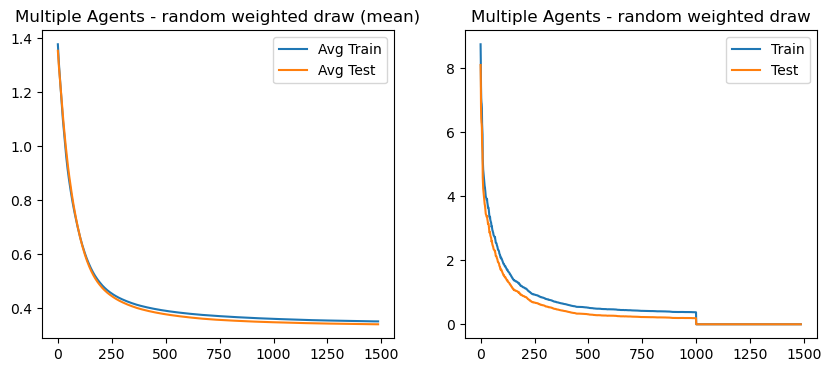

In [28]:
util.plot_curves_non_zero(num_agents, costs_train_agents_weigh_shifted, costs_test_agents_weigh_shifted, costs_train_weigh, costs_test_weigh, "Multiple Agents - random weighted draw")

## With Privacy

On fait avec $\delta = 0$ et $\epsilon_i(t_i) = \epsilon$

Si on veut partir du $\bar{\epsilon}$, on va utiliser $\delta$ et $\bar{\delta}$ tous nuls, et utiliser le théorème 1 (et la proposition 2 dans un deuxième temps) pour obtenir des epsilon.

Ici on peut avoir des $\bar{\epsilon}$ très élevés


In [29]:
epsilon = 0.5 # -> ici on a donc epsilon_barre = epsilon * T = 500
L_0 = 0.25

print(type(epsilon))

np.random.seed(seed)
thetas_private = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]

costs_train_private = np.zeros(T)
costs_test_private = np.zeros(T)

acc_train_private = np.zeros(T)
acc_test_private = np.zeros(T)

for i in range(T):
    thetas_private = ml.stepForwardPrivate(thetas_private, X_agent_augmented, Y_agent, num_agents, mu, c, G, D, L_0, epsilon)
    costs_train_private[i] = lr.costDecentralized(thetas_private, X_agent_augmented, Y_agent, num_agents, G, D, c, mu)
    costs_test_private[i] = lr.costDecentralized(thetas_private, X_test_augmented, Y_test, num_agents, G, D, c, mu)

    acc_train_private[i] = lr.accuracyAll(num_agents, thetas_private, X_agent_augmented, Y_agent)
    acc_test_private[i] = lr.accuracyAll(num_agents, thetas_private, [X_test_augmented for i in range(num_agents)], [Y_test for i in range(num_agents)])
    if i % (T/10) == 0 :
        print(f'Iteration {i} : Train: {costs_train_private[i]:.4f} | Test: {costs_test_private[i]:.4f}')

<class 'float'>
Iteration 0 : Train: 7.7239 | Test: 7.0819
Iteration 100 : Train: 1.8614 | Test: 1.4776
Iteration 200 : Train: 1.1368 | Test: 0.8509
Iteration 300 : Train: 0.8322 | Test: 0.5867
Iteration 400 : Train: 0.6641 | Test: 0.4388
Iteration 500 : Train: 0.5671 | Test: 0.3533
Iteration 600 : Train: 0.5069 | Test: 0.3008
Iteration 700 : Train: 0.4632 | Test: 0.2627
Iteration 800 : Train: 0.4396 | Test: 0.2434
Iteration 900 : Train: 0.4191 | Test: 0.2260


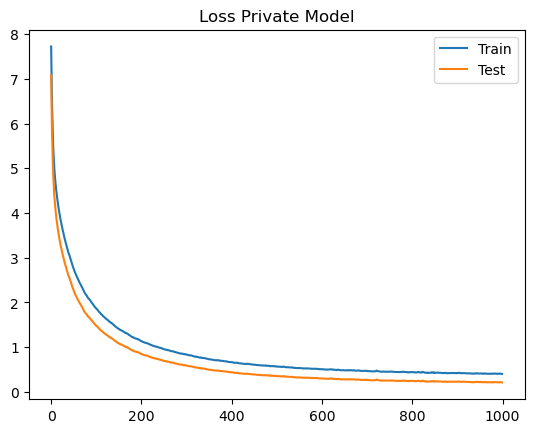

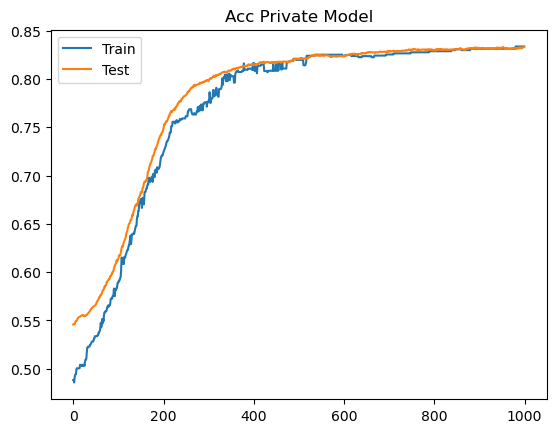

In [30]:
plt.plot(costs_train_private, label="Train")
plt.plot(costs_test_private, label="Test")
plt.title("Loss Private Model")
plt.legend()
plt.show()

plt.plot(acc_train_private, label="Train")
plt.plot(acc_test_private, label="Test")
plt.title("Acc Private Model")
plt.legend()
plt.show()

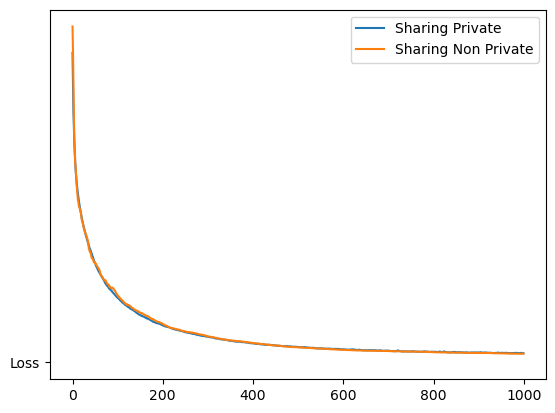

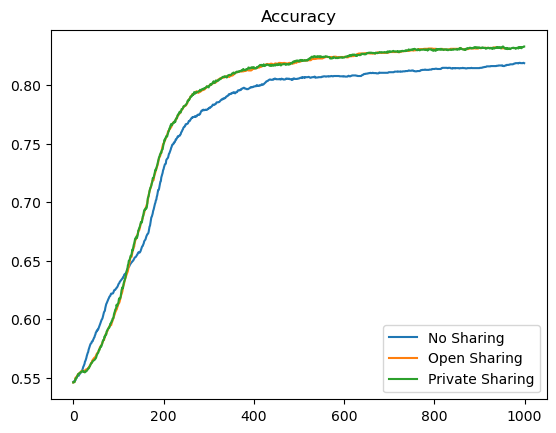

In [31]:
plt.plot(costs_test_private, label="Sharing Private")
#plt.plot(costs_test_alone, label="No Sharing")
plt.plot(costs_test_rand, label="Sharing Non Private")
plt.plot("Loss")
plt.legend()
plt.show()

plt.plot(np.mean(acc_test_agents_alone, axis=1), label="No Sharing")
plt.plot(np.mean(acc_test_agents_rand, axis=1), label="Open Sharing")
plt.plot(acc_test_private, label="Private Sharing")
plt.title("Accuracy")
plt.legend()
plt.show()

### Random drawing using constant epsilon

In [32]:

# epsilon = epsilon_barre / T # pour stepForwardPrivate normal

# il faut réestimer le epsilon_barre lorsque le nombre d'étapes d'entraînement pour un modèle n'est pas exactement T 

#epsilon_barre = 500

epsilon = 0.5
L_0 = 0.25

print(type(epsilon))

np.random.seed(seed)
tracking  = np.zeros(num_agents) # pour mesurer le nombre de fois que chaque agent passe
total_T = T*num_agents

thetas_agents_private_rand = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]
costs_test_agents_private_rand = np.zeros((total_T, num_agents))                 # ici on ne gardera en mémoire que les dernières valeurs
costs_train_agents_private_rand = np.zeros((total_T, num_agents))

costs_test_private_rand = np.zeros(total_T)
costs_train_private_rand = np.zeros(total_T)


print("Iter: Agents_Mean       | Total ")
for i in range (total_T) :
    j = rd.randint(0, num_agents-1)
    tracking[j] += 1

    thetas_agents_private_rand = ml.stepForwardPrivate_2(thetas_agents_private_rand, X_agent_augmented, Y_agent, j, num_agents, mu, c, G, D, L_0, epsilon) 

    costs_train_agents_private_rand[i, j] = lr.cost(thetas_agents_private_rand[j], X_agent_augmented[j], Y_agent[j])
    costs_test_agents_private_rand[i, j] = lr.cost(thetas_agents_private_rand[j], X_test_augmented, Y_test)

    if i % 10 == 0:
        costs_train_private_rand[int(i/10)] = lr.costDecentralized(thetas_agents_private_rand, X_agent_augmented, Y_agent, num_agents, G, D, c, mu)
        costs_test_private_rand[int(i/10)] = lr.costDecentralized(thetas_agents_private_rand, X_test_augmented, Y_test, num_agents, G, D, c, mu)
        
    if i % ((T/10)*num_agents) == 0 :
        print(f'{int(i/num_agents):3} : ({np.mean(costs_train_agents_private_rand[i]):.4f} , {np.mean(costs_test_agents_private_rand[i]):.4f}) | ({costs_train_private_rand[int(i/10)]:.4f} , {costs_test_private_rand[int(i/10)]:.4f})')

costs_train_agents_private_rand = util.reduce_cost_matrix(costs_train_agents_private_rand)
costs_test_agents_private_rand = util.reduce_cost_matrix(costs_test_agents_private_rand)
costs_train_private_rand = costs_train_private_rand[:T]
costs_test_private_rand = costs_test_private_rand[:T]

<class 'float'>
Iter: Agents_Mean       | Total 
  0 : (0.1520 , 0.1576) | (8.7392 , 8.0920)
100 : (0.0699 , 0.0618) | (1.8809 , 1.4945)
200 : (0.0482 , 0.0454) | (1.1619 , 0.8777)
300 : (0.0463 , 0.0440) | (0.8280 , 0.5819)
400 : (0.0443 , 0.0421) | (0.6620 , 0.4360)
500 : (0.0417 , 0.0405) | (0.5647 , 0.3509)
600 : (0.0415 , 0.0392) | (0.5093 , 0.3027)
700 : (0.0345 , 0.0346) | (0.4582 , 0.2572)
800 : (0.0370 , 0.0362) | (0.4284 , 0.2319)
900 : (0.0416 , 0.0366) | (0.4216 , 0.2286)


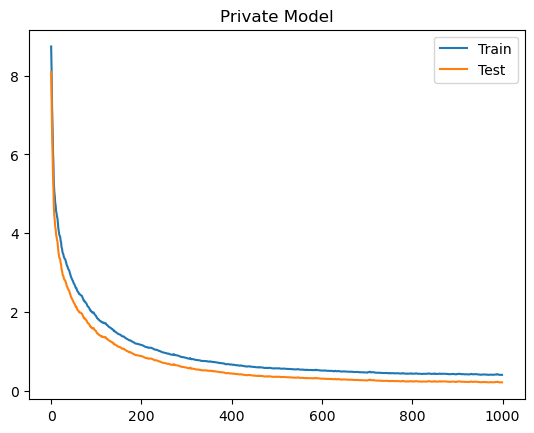

In [33]:
plt.plot(costs_train_private_rand, label="Train")
plt.plot(costs_test_private_rand, label="Test")
plt.title("Private Model")
plt.legend()
plt.show()

### Weighted drawing with constant epsilons

In [34]:

# DEFINING EPSILON_BAR
epsilon_barre = 500
L_0 = 0.25

np.random.seed(seed)
tracking  = np.zeros(num_agents)
total_T = T*num_agents

thetas_agents_private_weigh = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]
costs_test_agents_private_weigh = np.zeros((total_T, num_agents))                 # ici on ne gardera en mémoire que les dernières valeurs
costs_train_agents_private_weigh = np.zeros((total_T, num_agents))

costs_test_private_weigh = np.zeros(total_T)
costs_train_private_weigh = np.zeros(total_T)


# on obtient les probabilités qu'on veut pour chaque modèle à chaque tirage
coeffs_pond = np.zeros(num_agents)
c_tot = 0
for i in range (len(c)) :
    c_tot += c[i]    
for i in range (len(c)) :
    coeffs_pond[i] = c[i]/c_tot
    
# des probabilités, on déduit l'espérance du nombre d'itérations pour chaque agent
nb_iterations = np.zeros(num_agents)
for i in range (num_agents):
    nb_iterations = coeffs_pond * total_T


# puis les epsilon correspondants pour chaque agent
epsilon = np.zeros(num_agents)
for i in range(num_agents): 
    epsilon[i] = epsilon_barre / nb_iterations[i]
"""
print("Agent : Iterations  | epsilon | epsilon_barre")
for i in range(num_agents):
    print(f'{int(i):3} : ({nb_iterations[i]:.4f}) | ({epsilon[i]:.4f}) | ({epsilon[i]*nb_iterations[i]})')
"""
print()

print("Iter: Agents_Mean       | Total ")

for i in range(total_T) :
    j = np.random.choice(10, 1, p=coeffs_pond)[0]
    tracking[j] += 1

    thetas_agents_private_weigh = ml.stepForwardPrivate_2(thetas_agents_private_weigh, X_agent_augmented, Y_agent, j, num_agents, mu, c, G, D, L_0, epsilon[j])

    costs_train_agents_private_weigh[i, j] = (lr.cost(thetas_agents_private_weigh[j], X_agent_augmented[j], Y_agent[j]))
    costs_test_agents_private_weigh[i, j] = (lr.cost(thetas_agents_private_weigh[j], X_test_augmented, Y_test))

    if i % 10 == 0:
        costs_train_private_weigh[int(i/10)] = lr.costDecentralized(thetas_agents_private_weigh, X_agent_augmented, Y_agent, num_agents, G, D, c, mu)
        costs_test_private_weigh[int(i/10)] = lr.costDecentralized(thetas_agents_private_weigh, X_test_augmented, Y_test, num_agents, G, D, c, mu)
        
        
    if i % ((T/10)*num_agents) == 0 :
        print(f'{int(i/num_agents):3} : ({np.mean(costs_train_agents_private_weigh[i]):.4f} , {np.mean(costs_test_agents_private_weigh[i]):.4f}) | ({costs_train_private_weigh[int(i/10)]:.4f} , {costs_test_private_weigh[int(i/10)]:.4f})')

# costs_train_agents_weigh = util.reduce_cost_matrix(costs_train_agents_weigh)
# costs_test_agents_weigh = util.reduce_cost_matrix(costs_test_agents_weigh)

costs_train_agents_private_weigh_shifted = util.shift_non_zero_costs_to_front(costs_train_agents_private_weigh)
costs_test_agents_private_weigh_shifted = util.shift_non_zero_costs_to_front(costs_test_agents_private_weigh)

non_zero_counts = np.count_nonzero(costs_train_agents_private_weigh_shifted, axis=0)    
max_non_zero = np.max(non_zero_counts)
costs_train_private_weigh = costs_train_private_weigh[:T]
costs_test_private_weigh = costs_test_private_weigh[:T]



Iter: Agents_Mean       | Total 
  0 : (0.1520 , 0.1576) | (8.7393 , 8.0921)
100 : (0.0666 , 0.0654) | (1.9463 , 1.5809)
200 : (0.0490 , 0.0465) | (1.2131 , 0.9394)
300 : (0.0436 , 0.0415) | (0.8560 , 0.6205)
400 : (0.0384 , 0.0361) | (0.6288 , 0.4120)
500 : (0.0383 , 0.0372) | (0.5210 , 0.3143)
600 : (0.0372 , 0.0372) | (0.4770 , 0.2771)
700 : (0.0357 , 0.0339) | (0.4544 , 0.2596)
800 : (0.0352 , 0.0335) | (0.4186 , 0.2275)
900 : (0.0313 , 0.0345) | (0.4102 , 0.2222)


In [35]:
print("Iter: Total_Mean_rand   | Total_Mean_weigh")
for i in range (total_T):
    if i % ((T/10)*num_agents) == 0 :
        print(f'{int(i/num_agents):3} : ({costs_train_private_rand[int(i/10)]:.4f} , {costs_test_private_rand[int(i/10)]:.4f}) | (({costs_train_private_weigh[int(i/10)]:.4f} , {costs_test_private_weigh[int(i/10)]:.4f})')


Iter: Total_Mean_rand   | Total_Mean_weigh
  0 : (8.7392 , 8.0920) | ((8.7393 , 8.0921)
100 : (1.8809 , 1.4945) | ((1.9463 , 1.5809)
200 : (1.1619 , 0.8777) | ((1.2131 , 0.9394)
300 : (0.8280 , 0.5819) | ((0.8560 , 0.6205)
400 : (0.6620 , 0.4360) | ((0.6288 , 0.4120)
500 : (0.5647 , 0.3509) | ((0.5210 , 0.3143)
600 : (0.5093 , 0.3027) | ((0.4770 , 0.2771)
700 : (0.4582 , 0.2572) | ((0.4544 , 0.2596)
800 : (0.4284 , 0.2319) | ((0.4186 , 0.2275)
900 : (0.4216 , 0.2286) | ((0.4102 , 0.2222)


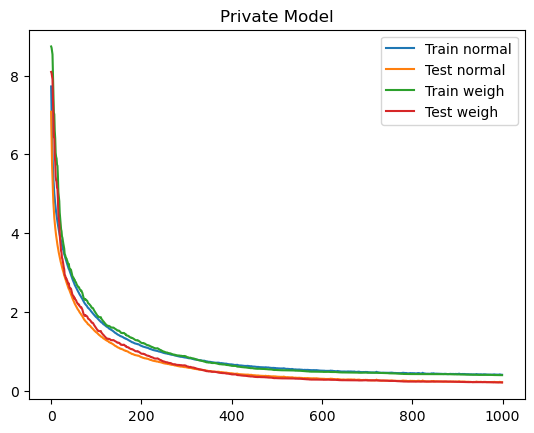

In [36]:
plt.plot(costs_train_private, label="Train normal")
plt.plot(costs_test_private, label="Test normal")
plt.plot(costs_train_private_weigh, label="Train weigh")
plt.plot(costs_test_private_weigh, label="Test weigh")
plt.title("Private Model")
plt.legend()
plt.show()

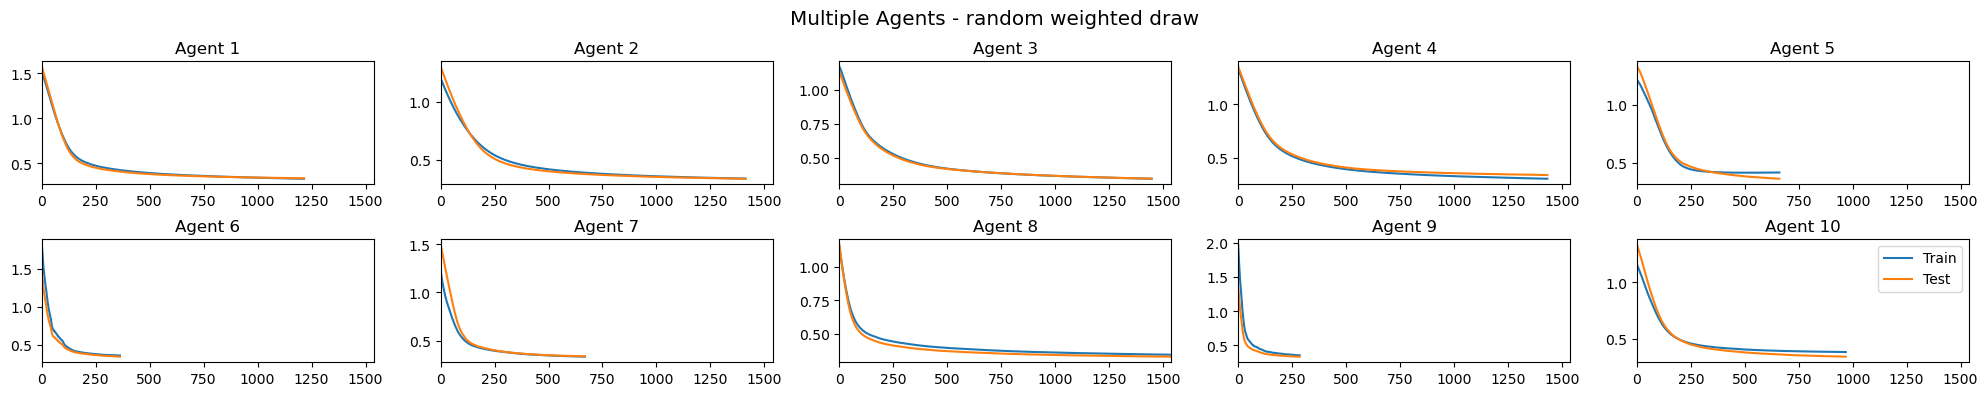

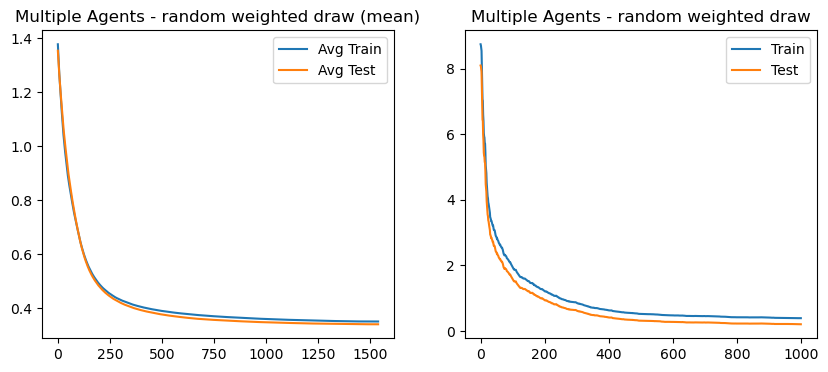

In [37]:
util.plot_curves_non_zero(num_agents, costs_train_agents_private_weigh_shifted, costs_test_agents_private_weigh_shifted, costs_train_private_weigh, costs_test_private_weigh, "Multiple Agents - random weighted draw")

### Weighted epsilons  implementing theorem 2 : optimal choice of epsilon

In [38]:

np.random.seed(seed)
tracking  = np.zeros(num_agents)
total_T = T*num_agents

thetas_agents_private_weigh_2 = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]
costs_test_agents_private_weigh_2 = np.zeros((total_T, num_agents))                 # ici on ne gardera en mémoire que les dernières valeurs
costs_train_agents_private_weigh_2 = np.zeros((total_T, num_agents))
costs_test_private_weigh_2 = np.zeros(total_T)
costs_train_private_weigh_2 = np.zeros(total_T)



# on obtient les probabilités qu'on veut pour chaque modèle à chaque tirage
coeffs_pond = np.zeros(num_agents)
c_tot = 0
for i in range (len(c)) :
    c_tot += c[i]    
for i in range (len(c)) :
    coeffs_pond[i] = c[i]/c_tot
    
# on doit calculer grand C = 1 - sigma /(n*Lmax)
# sigma - strongly convex  : correspond à Ql
# Lmax : max Li, les Li sont les constantesblock lipschitz du gradient de Ql
sigma = 0.05                                                                                       # randomly chosen at the moment
Lmax = 20
epsilon_bar = 500
L_0 = 0.25

big_c = 1 - sigma/(num_agents*Lmax)
cube = big_c ** (1/3)
print(cube)
print()

lambdas = np.zeros(num_agents)
agent_choice = np.zeros(total_T)
agent_pre = np.zeros(total_T)
epsilons = np.zeros(total_T)

# we have to know in advance at which iterations each machine wakes up, and we compute our lambdas


for i in range(total_T) :
    j = np.random.choice(10, 1, p=coeffs_pond)[0]
    agent_choice[i] = j
    res = (cube-1) / ((cube ** total_T)-1) * (cube ** (i+1))
    agent_pre[i] = res
    lambdas[j] += res
    
for i in range(total_T) :
    epsilons[i] = agent_pre[i] * epsilon_bar / lambdas[int(agent_choice[i])]
    

count = 0
sum = 0
epsi_by_agent  = np.zeros(num_agents)
count_by_agent = np.zeros(num_agents)
first = np.zeros(num_agents)
last = np.zeros(num_agents)

for i in range(total_T):    
    if epsi_by_agent[int(agent_choice[i])] == 0:
        first[int(agent_choice[i])] = epsilons[i]
    last[int(agent_choice[i])] = epsilons[i]
    epsi_by_agent[int(agent_choice[i])] +=epsilons[i]
    count_by_agent[int(agent_choice[i])] += 1
    
for i in range(num_agents):
    epsi_by_agent[i] = epsi_by_agent[i] / count_by_agent[i]

rate_epsi = first - last


print(coeffs_pond)
print("Iter: Agents_Mean       | Total ")

for i in range(total_T) :
    j = int(agent_choice[i])
    epsi = epsilons[i]
    thetas_agents_private_weigh_2 = ml.stepForwardPrivate_2(thetas_agents_private_weigh_2, X_agent_augmented, Y_agent, j, num_agents, mu, c, G, D, L_0, epsi)

    costs_train_agents_private_weigh_2[i, j] = (lr.cost(thetas_agents_private_weigh_2[j], X_agent_augmented[j], Y_agent[j]))
    costs_test_agents_private_weigh_2[i, j] = (lr.cost(thetas_agents_private_weigh_2[j], X_test_augmented, Y_test))

    if i % 10 == 0:
        costs_train_private_weigh_2[int(i/10)] = lr.costDecentralized(thetas_agents_private_weigh_2, X_agent_augmented, Y_agent, num_agents, G, D, c, mu)
        costs_test_private_weigh_2[int(i/10)] = lr.costDecentralized(thetas_agents_private_weigh_2, X_test_augmented, Y_test, num_agents, G, D, c, mu)
        
        
    if i % ((T/10)*num_agents) == 0 :
        print(f'{int(i/num_agents):3} : ({np.mean(costs_train_agents_private_weigh_2[i]):.4f} , {np.mean(costs_test_agents_private_weigh_2[i]):.4f}) | ({costs_train_private_weigh_2[int(i/10)]:.4f} , {costs_test_private_weigh_2[int(i/10)]:.4f})')

# costs_train_agents_weigh_2 = util.reduce_cost_matrix(costs_train_agents_weigh_2)
# costs_test_agents_weigh_2 = util.reduce_cost_matrix(costs_test_agents_weigh_2)

costs_train_agents_private_weigh_shifted_2 = util.shift_non_zero_costs_to_front(costs_train_agents_private_weigh_2)
costs_test_agents_private_weigh_shifted_2 = util.shift_non_zero_costs_to_front(costs_test_agents_private_weigh_2)

non_zero_counts = np.count_nonzero(costs_train_agents_private_weigh_shifted_2, axis=0)    
max_non_zero = np.max(non_zero_counts)
costs_train_private_weigh_2 = costs_train_private_weigh_2[:T]
costs_test_private_weigh_2 = costs_test_private_weigh_2[:T]

0.9999166597212575

[0.11666667 0.14333333 0.14833333 0.14333333 0.07166667 0.03666667
 0.06666667 0.15166667 0.025      0.09666667]
Iter: Agents_Mean       | Total 
  0 : (0.1520 , 0.1576) | (8.7394 , 8.0922)
100 : (0.0703 , 0.0675) | (2.0023 , 1.6428)
200 : (0.0508 , 0.0510) | (1.1521 , 0.8805)
300 : (0.0427 , 0.0409) | (0.7992 , 0.5650)
400 : (0.0425 , 0.0407) | (0.6185 , 0.4022)
500 : (0.0358 , 0.0378) | (0.5212 , 0.3150)
600 : (0.0371 , 0.0372) | (0.4717 , 0.2721)
700 : (0.0350 , 0.0348) | (0.4380 , 0.2435)
800 : (0.0352 , 0.0335) | (0.4152 , 0.2244)
900 : (0.0417 , 0.0367) | (0.3876 , 0.1998)


In [39]:
print("Iter: Total_Mean_rand   | Total_Mean_weigh")
for i in range (total_T):
    if i % ((T/10)*num_agents) == 0 :
        print(f'{int(i/num_agents):3} : ({costs_train_private_weigh[int(i/10)]:.4f} , {costs_test_private_weigh[int(i/10)]:.4f}) | (({costs_train_private_weigh_2[int(i/10)]:.4f} , {costs_test_private_weigh_2[int(i/10)]:.4f})')


Iter: Total_Mean_rand   | Total_Mean_weigh
  0 : (8.7393 , 8.0921) | ((8.7394 , 8.0922)
100 : (1.9463 , 1.5809) | ((2.0023 , 1.6428)
200 : (1.2131 , 0.9394) | ((1.1521 , 0.8805)
300 : (0.8560 , 0.6205) | ((0.7992 , 0.5650)
400 : (0.6288 , 0.4120) | ((0.6185 , 0.4022)
500 : (0.5210 , 0.3143) | ((0.5212 , 0.3150)
600 : (0.4770 , 0.2771) | ((0.4717 , 0.2721)
700 : (0.4544 , 0.2596) | ((0.4380 , 0.2435)
800 : (0.4186 , 0.2275) | ((0.4152 , 0.2244)
900 : (0.4102 , 0.2222) | ((0.3876 , 0.1998)


In [40]:


print("Agent : Iterations  | epsilon | epsilon_barre")
for i in range(num_agents):
    print(f'{int(i):3} : ({nb_iterations[i]:.4f}) | ({epsilon[i]:.4f}) | ({epsilon[i]*nb_iterations[i]})')

print()
print("Agent : Iterations  | epsilon | epsilon_barre | delta_epsilon ")
for i in range(num_agents):
    print(f'{int(i):3} : ({count_by_agent[i]:.4f}) | ({epsi_by_agent[i]:.4f}) | ({epsi_by_agent[i]*count_by_agent[i]}) | ({rate_epsi[i]:.4f}))')

Agent : Iterations  | epsilon | epsilon_barre
  0 : (1166.6667) | (0.4286) | (500.0)
  1 : (1433.3333) | (0.3488) | (500.0)
  2 : (1483.3333) | (0.3371) | (500.0)
  3 : (1433.3333) | (0.3488) | (500.0)
  4 : (716.6667) | (0.6977) | (500.0)
  5 : (366.6667) | (1.3636) | (500.0)
  6 : (666.6667) | (0.7500) | (500.00000000000006)
  7 : (1516.6667) | (0.3297) | (500.0)
  8 : (250.0000) | (2.0000) | (500.0)
  9 : (966.6667) | (0.5172) | (500.0)

Agent : Iterations  | epsilon | epsilon_barre | delta_epsilon 
  0 : (1192.0000) | (0.4195) | (500.0000000000002) | (0.3472))
  1 : (1462.0000) | (0.3420) | (499.9999999999999) | (0.2853))
  2 : (1486.0000) | (0.3365) | (499.99999999999966) | (0.2825))
  3 : (1468.0000) | (0.3406) | (500.0000000000002) | (0.2870))
  4 : (721.0000) | (0.6935) | (499.99999999999915) | (0.5733))
  5 : (367.0000) | (1.3624) | (500.0000000000001) | (1.1044))
  6 : (666.0000) | (0.7508) | (500.00000000000017) | (0.6235))
  7 : (1472.0000) | (0.3397) | (500.0000000000001) 

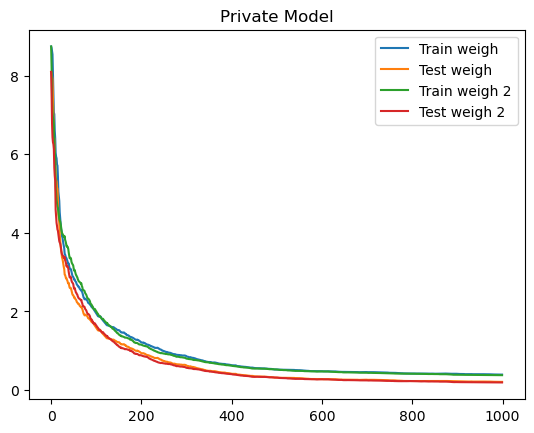

In [41]:
#plt.plot(costs_train_private, label="Train normal")
#plt.plot(costs_test_private, label="Test normal")
plt.plot(costs_train_private_weigh, label="Train weigh")
plt.plot(costs_test_private_weigh, label="Test weigh")
plt.plot(costs_train_private_weigh_2, label="Train weigh 2")
plt.plot(costs_test_private_weigh_2, label="Test weigh 2")
plt.title("Private Model")
plt.legend()
plt.show()

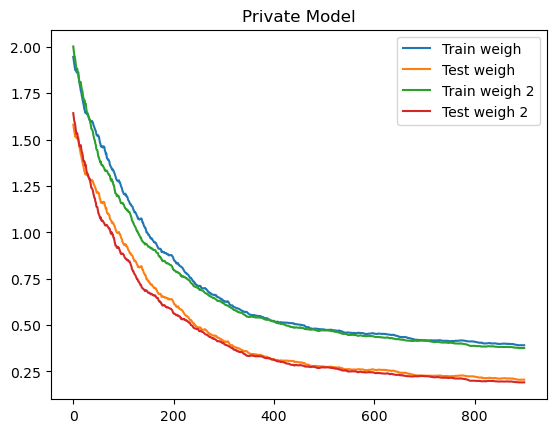

In [42]:
costs_train_private_weigh = costs_train_private_weigh[100:]
costs_test_private_weigh = costs_test_private_weigh[100:]
costs_train_private_weigh_2 = costs_train_private_weigh_2[100:]
costs_test_private_weigh_2 = costs_test_private_weigh_2[100:]

plt.plot(costs_train_private_weigh, label="Train weigh")
plt.plot(costs_test_private_weigh, label="Test weigh")
plt.plot(costs_train_private_weigh_2, label="Train weigh 2")
plt.plot(costs_test_private_weigh_2, label="Test weigh 2")
plt.title("Private Model")
plt.legend()
plt.show()

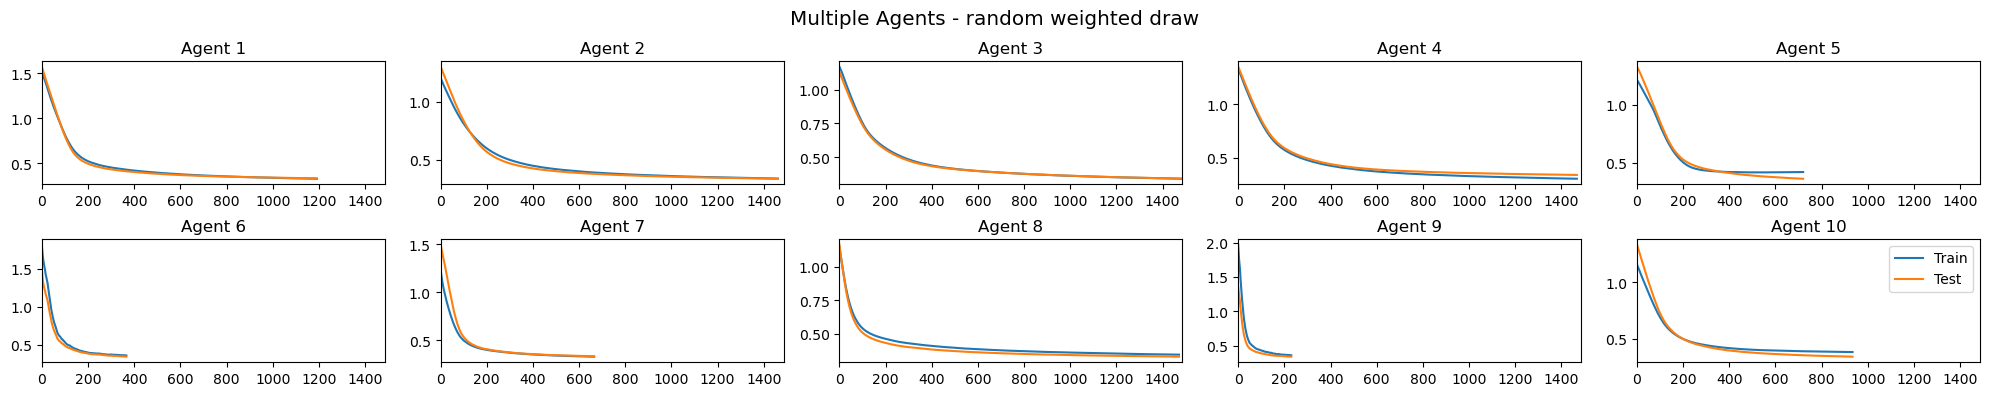

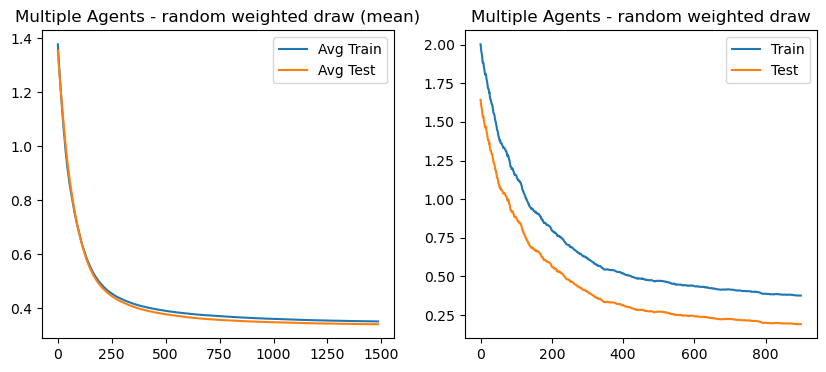

In [43]:
util.plot_curves_non_zero(num_agents, costs_train_agents_private_weigh_shifted_2, costs_test_agents_private_weigh_shifted_2, costs_train_private_weigh_2, costs_test_private_weigh_2, "Multiple Agents - random weighted draw")